In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pickle
import os

# from lstm_model import *
# from preprocess import *
# from notes_dataset import *

import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class NotesDataset(Dataset):

    def __init__(self, in_sequences, out_sequences):
        self.in_sequences = torch.from_numpy(in_sequences).float()
        self.in_sequences.to(device)
        self.out_sequences = torch.from_numpy(out_sequences)
        self.out_sequences.to(device)

    def __len__(self):
        return len(self.in_sequences)

    def __getitem__(self, idx):
        return self.in_sequences[idx], self.out_sequences[idx]

In [ ]:
class LSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, vocab_size, dropout_prob=0.3):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        #self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes measures as inputs, and outputs hidden states
        # with dimensionality hidden_dim.d
        self.lstm1 = nn.LSTM(input_size=input_dim[1], hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.bn1 = nn.BatchNorm1d(num_features=input_dim[1], affine=False)
        self.linear1 = nn.Linear(in_features=hidden_dim, out_features=256)
        self.bn2 = nn.BatchNorm1d(num_features=input_dim[1], affine=False)
        self.relu = nn.ReLU(inplace=False)
        self.linear2 = nn.Linear(in_features=256, out_features=vocab_size)

        #self.output = nn.LogSoftmax()


    def forward(self, measure):

        lstm_out1, _ = self.lstm1(measure)
        lstm_out1 = self.dropout(lstm_out1)

        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout(lstm_out2)

        lstm_out3, (h_n, c_n) = self.lstm3(lstm_out2)
        h_n = h_n.permute(1, 0, 2)
        h_n = self.bn1(h_n)
        h_n = self.dropout(h_n)

        linear_out1 = self.linear1(h_n)

        relu_out = self.relu(linear_out1)
        relu_out = self.bn2(relu_out)
        relu_out = self.dropout(relu_out)

        linear_out2 = self.linear2(relu_out)

        return linear_out2

In [ ]:
EPOCHS = 30
BATCH_SIZE = 64
MODEL_PATH = './best_model.pth'

print('EPOCHS: {}\nBATCH_SIZE: {}'.format(EPOCHS, BATCH_SIZE))

if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'

print('Using device: {}'.format(device))




EPOCHS: 30
BATCH_SIZE: 64
Using device: cuda:0


In [ ]:
def load_data(set_name):
    set_path = './{}_notes'.format(set_name)
    with open(set_path, 'rb') as f:
        notes = pickle.load(f)

    vocab_size = len(set(notes))

    if os.path.exists('note_to_int_dict'):
        with open('note_to_int_dict', 'rb') as f:
            notes_to_int = pickle.load(f)
    else:
        notes_to_int = None
    return notes, vocab_size, notes_to_int

def prepare_sequences(notes, n_vocab, set_name, note_to_int=None):
    """ Prepare the sequences used by the Neural Network """
    set_path = './{}_notes'.format(set_name)

    if os.path.exists(set_path + '_input.npy') and os.path.exists(set_path + '_output.npy'):
        network_input = np.load(set_path + '_input.npy')
        network_output = np.load(set_path + '_output.npy')

        return network_input, network_output

    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    if set_name == 'train':
        note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    end = min(len(notes) - sequence_length, 350000)
    for i in range(0, end, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([(note_to_int[char] if char in note_to_int else 0) for char in sequence_in])
        network_output.append(note_to_int[sequence_out ] if sequence_out in note_to_int else 0)

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np.array(network_output)

    np.save(set_path + '_input', network_input)
    np.save(set_path + '_output', network_output)
    if set_name == 'train':
        with open('note_to_int_dict', 'wb') as f:
            pickle.dump(note_to_int, f)


    return network_input, network_output

In [ ]:
def train():
    notes, vocab_size, _ = load_data('train')
    input_sequences, output_sequences = prepare_sequences(notes, vocab_size, 'train')

    model = LSTMModel(input_dim=input_sequences.shape[1:], hidden_dim=512, vocab_size=vocab_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    start_epoch, min_loss = 0, 100
    loss_values, block_loss = [], []

    if os.path.exists('LSTMModel/best_model.pth'):
        start_epoch, model, optimizer, min_loss, loss_values = load_checkpoint(MODEL_PATH, model, optimizer)
        print('Loaded checkpoint. Starting epoch {}'.format(start_epoch))

    model = model.to(device)
    model.train()

    training_set = NotesDataset(input_sequences, output_sequences)
    trainloader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    loss_function = nn.CrossEntropyLoss().to(device)

    for epoch in range(start_epoch, EPOCHS):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):

            inputs, labels = inputs.to(device), labels.to(device)
            inputs.requires_grad_(True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs).squeeze()
            loss = loss_function(input=outputs, target=labels.long())
            loss.backward()
            optimizer.step()

            block_loss.append(loss.item())

            if i % 500 == 0:
                print('Epoch: {}\tIteration: {}\tLoss: {}'.format(epoch, i, np.array(block_loss).mean()))
                current_block_loss = np.array(block_loss).mean()
                loss_values.append(current_block_loss)
                if current_block_loss < min_loss:
                    min_loss = current_block_loss

                    save_dict = {'epoch': epoch,
                                'state_dict': model.state_dict(),
                                'optimizer': optimizer.state_dict(),
                                'min_loss': min_loss,
                                'loss': loss_values}
                    torch.save(save_dict, MODEL_PATH)
                    # print statistics
                    print('Saving checkpoint. Best loss: {}'.format(min_loss))

                block_loss = []



    return loss_values




In [ ]:
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

    return epoch, model, optimizer, checkpoint['min_loss'], checkpoint['loss'] if 'loss' in checkpoint else []




Epoch: 0	Iteration: 0	Loss: 7.469720840454102
Saving checkpoint. Best loss: 7.469720840454102
Epoch: 0	Iteration: 500	Loss: 5.380538787841797
Saving checkpoint. Best loss: 5.380538787841797
Epoch: 0	Iteration: 1000	Loss: 4.721335883617401
Saving checkpoint. Best loss: 4.721335883617401
Epoch: 0	Iteration: 1500	Loss: 5.408646466255188
Epoch: 0	Iteration: 2000	Loss: 5.045155834197998
Epoch: 0	Iteration: 2500	Loss: 4.858716126918793
Epoch: 0	Iteration: 3000	Loss: 4.6588606133461
Saving checkpoint. Best loss: 4.6588606133461
Epoch: 0	Iteration: 3500	Loss: 4.716134910583496
Epoch: 0	Iteration: 4000	Loss: 4.441656496524811
Saving checkpoint. Best loss: 4.441656496524811
Epoch: 0	Iteration: 4500	Loss: 4.697829163074493
Epoch: 0	Iteration: 5000	Loss: 4.652025275707245
Epoch: 1	Iteration: 0	Loss: 4.660694455795451
Epoch: 1	Iteration: 500	Loss: 4.85018949508667
Epoch: 1	Iteration: 1000	Loss: 4.603122758865356
Epoch: 1	Iteration: 1500	Loss: 5.311082330703735
Epoch: 1	Iteration: 2000	Loss: 4.96213

FileNotFoundError: [Errno 2] No such file or directory: 'LSTMModel/loss.png'

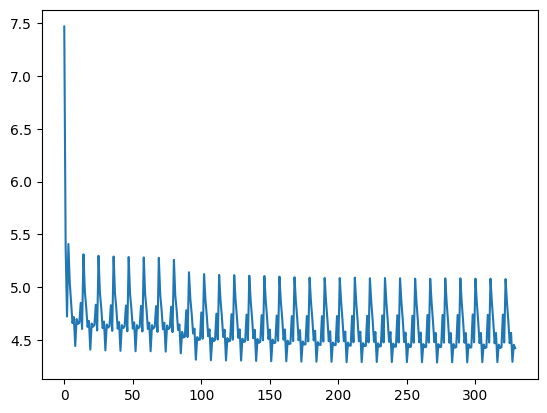

In [ ]:
loss_values = train()
plt.figure()
plt.plot(loss_values)
plt.savefig('LSTMModel/loss.png', dpi=600)
np.save('loss_values_epoch{}_batchsize{}'.format(EPOCHS, BATCH_SIZE), loss_values)

In [ ]:
# inferencing
def sample_from_softmax(softmax_probs):
    # Ensure probabilities sum up to 1
    softmax_probs = softmax_probs / np.sum(softmax_probs)

    # Sample from multinomial distribution using softmax probabilities
    sample_index = np.random.choice(len(softmax_probs), p=softmax_probs)

    return sample_index

device = "cuda:2" if torch.cuda.is_available() else "cpu"

notes, vocab_size, notes_to_int = load_data('test')
input_sequences, output_sequences = prepare_sequences(notes, vocab_size, 'test', notes_to_int)

testing_set = NotesDataset(input_sequences, output_sequences)
testloader = DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


trainnotes, trainvocab_size, _ = load_data('train')
traininput_sequences, trainoutput_sequences = prepare_sequences(trainnotes, trainvocab_size, 'train')
model = LSTMModel(input_dim=traininput_sequences.shape[1:], hidden_dim=512, vocab_size=trainvocab_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
start_epoch, model, optimizer, min_loss, loss_values = load_checkpoint(MODEL_PATH, model, optimizer)
model.eval()

results = []
predictions = np.array([], dtype=np.int64)

for i, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device)[0].reshape((1,-1,1)), labels.to(device)
    break

with torch.no_grad():
    for i in range(101):
        # forward + backward + optimize
        outputs = model(inputs).squeeze()
        outputs = outputs.cpu().detach().numpy()
        pred = torch.tensor(sample_from_softmax(np.exp(outputs))).reshape(1, -1, 1).to(device)

        inputs = torch.cat((inputs, pred/vocab_size) ,axis =1 )

In [ ]:
int2note = {v:k for k,v in notes_to_int.items()}

output = inputs.cpu().detach().numpy()
output[:100] = output[:100] * vocab_size
output[100:] = output[100:] * vocab_size
notes_prediction = np.vectorize(lambda x: int2note.get(round(x), int2note[0]))(output)

In [ ]:
notes_prediction.reshape(-1)

array(['A4', 'E4', 'B-3', 'E5', 'F#5', 'A5', 'C6', 'C5', 'F#4', 'C#5',
       'E5', 'F#5', 'A5', 'C6', 'C5', 'F#5', 'E-6', 'F#4', 'G3', 'C#4',
       'C#5', 'E-5', 'F#5', 'A5', 'A4', 'E-4', 'B-4', 'C#5', 'E-5', 'F#5',
       'A5', 'A4', 'E-5', 'C6', 'F#3', 'E4', '10.1', 'E5', 'F#5', 'A5',
       'C6', 'F#3', '1.4', 'E5', 'B-4', 'F#5', '9.0', 'C4', 'D5', 'B-4',
       'E5', 'F#5', '10.0', 'F#4', 'C#5', '4.6', '9.0', 'C5', '2.4',
       '6.10.0', 'F#5', 'C#5', '4.7', 'A5', '0.1', 'E6', 'G6', 'A6', 'C7',
       'G6', 'E6', 'C#6', 'C6', 'A5', '4.7', 'C#5', 'A4', 'A4', 'E4',
       'B-3', 'E5', 'F#5', 'A5', 'C6', 'C5', 'F#4', 'C#5', 'E5', 'F#5',
       'A5', 'C6', 'C5', 'F#5', 'E-6', 'C5', 'C#4', 'G4', 'G5', 'A5',
       'C6', '1.5', 'B-4', 'D5', 'F4', '0.2', '3.5', 'B2', '10', '1',
       'B-3', 'G4', '9.2', 'C3', 'F3', 'B2', '1.4', 'G5', 'G3', 'F4',
       'C2', '10.0', 'G4', '3.6', '2.6', '1.4', 'D4', '1', '3.7', '5.10',
       '7.11', '5.8', 'A4', 'B4', 'D4', '5.11', '10', 'F#5', '3', '

In [ ]:
from music21 import stream, note, chord

def notes_to_audio(notes):
    s = stream.Stream()

    for note_name in notes:
        if '.' not in note_name and not note_name.isdigit():
            s.append(note.Note(note_name))
        else:
            pitches = note_name.split('.')
            chord_notes = [note.Note(int(p)) for p in pitches]
            s.append(chord.Chord(chord_notes))

    s.show('midi')

notes_to_audio(notes_prediction.reshape(-1))